Lew, Andrew J., and Markus J. Buehler. "Encoding and exploring latent design space of optimal material structures via a VAE-LSTM model." Forces in Mechanics 5 (2021): 100054.

In [2]:
###------------------Import packages-----------------------

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda, Dropout, Activation, RepeatVector, Conv1D, Conv2D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Try to install GPU version of TF")
print(tf.__version__)

In [4]:
###------------------Load latent space progression data for training-----------------------

# Define input/output for training progressions -----------------------------

#length of input sequences
seq_length=151

#Number of points predicted
pred=147

#Number of waves considered
num_waves=2 #Number of latent variable curves to plot, dealing with 2 latent variables

#We will predict "pred" and provide "seq_leng-pred"
print ("number of sequence as input:" ,seq_length-pred, "and predicted: ", pred)


number of sequence as input: 4 and predicted:  147


In [5]:
def train_generator(data, pred):
    x_train = data[:,:-pred,:]      
    y_train = data[:, -pred:, :]   
    return x_train, y_train

In [6]:
# Load Data --------------------------------------------
 
filen="TopOptSeries_large.data.npy" 
gray_data=np.load(filen, allow_pickle=True, fix_imports=True )

print ("Format of loaded data: ", gray_data.shape)
minn=np.amin (gray_data[np.nonzero(gray_data)])
maxx=np.amax (gray_data)

gray_data=gray_data[:,:,:] 

lenn=gray_data.shape[0]
xpix=gray_data.shape[1]
ypix=gray_data.shape[2]

label=np.arange(gray_data.shape[0])
label.shape
print ("length of original data: ", xpix,ypix, "min/max ", minn, maxx)

#Yields 'original data' in format progressions x encoding

# Slice Data --------------------------------------------

#Split encoding progressions into pieces for training
splitting=False
if splitting==True:
    #length of final data segments
    final_length=seq_length  
    numberdrawn = 3000
    
    np.random.seed(21)
    rrva = np.random.randint(0, xpix-final_length, size=numberdrawn)
    plt.plot(rrva,'.')
    plt.show()

    for iii in range (lenn): 
        plt.plot(gray_data[iii,:,0])
    plt.show()

    ll=0
    for j in range (lenn):
        print ("j= ", j, "max: ", lenn)
        for i in range (numberdrawn):
            value = rrva[i]
            tmpp=gray_data [j,  value: value+final_length, 0]
            tmpp=tmpp.flatten()

            is_all_zero = np. all((tmpp == 0))
            if not is_all_zero:
                if ll==0:
                    gray_data_new = np.array(tmpp)
                    label_new=np.array(j)
                else: 
                    gray_data_new=np.append ( gray_data_new, tmpp , axis=0 )
                    label_new=np.append (label_new, j)
                ll=ll+1

    #Augment and split data
    print ("before ", gray_data_new.shape, ll)
    gray_data_new=gray_data_new.reshape((ll,final_length,1))
    print ("after: ", gray_data_new.shape, label_new.shape)
    gray_data=gray_data_new
    label=label_new

    lenn=gray_data.shape[0]
    xpix=gray_data.shape[1]
    ypix=gray_data.shape[2]

    print (xpix, ypix, lenn)

Format of loaded data:  (48, 151, 2)
length of original data:  151 2 min/max  -2.8065919876098633 0.5048904418945312


In [7]:
#Save sliced data
filenXb='TopOptAll.npy'
np.save(filenXb, gray_data , allow_pickle=True, fix_imports=True)

In [8]:
###------------------Define and train LSTM model-----------------------

#Reload data and partition into train and test 
filenXb = "TopOptAll.npy" 
gray_data=np.load(filenXb, allow_pickle=True, fix_imports=True )
print(gray_data.shape)
print(seq_length, num_waves, pred) 
x_train, y_train = train_generator(gray_data, pred)
print (x_train.shape)
print (y_train.shape) 

from sklearn.model_selection import train_test_split 
x_train, x_test, y_train,  y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=7)
print (x_train.shape)
print (y_train.shape) 
print (x_test.shape)
print (y_test.shape) 


(48, 151, 2)
151 2 147
(48, 4, 2)
(48, 147, 2)
(38, 4, 2)
(38, 147, 2)
(10, 4, 2)
(10, 147, 2)


(4,)


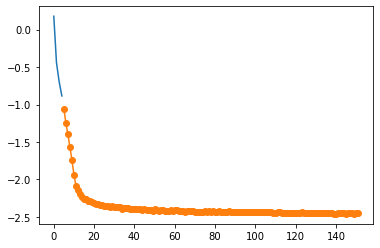

(4,)


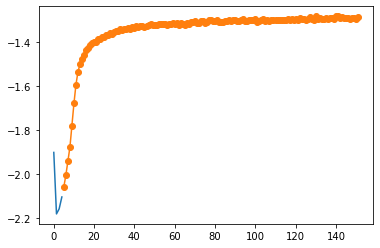

In [9]:
#Visualizing the progression of the two latent variables
#for a given volfrac, split by what will be input prog and what will be the pred prog

#First Latent Variable
print (np.linspace (0,seq_length-pred, num= seq_length-pred).shape)
plt.plot (np.linspace (0,seq_length-pred,num= seq_length-pred ), x_train[4,:,0], '-')
plt.plot (np.linspace (seq_length-pred+1,seq_length,num=  pred ), y_train[4,:,0], 'o-')
plt.show()

#Second Latent Variable
print (np.linspace (0,seq_length-pred, num= seq_length-pred).shape)
plt.plot (np.linspace (0,seq_length-pred,num= seq_length-pred ), x_train[4,:,1], '-')
plt.plot (np.linspace (seq_length-pred+1,seq_length,num=  pred ), y_train[4,:,1], 'o-')
plt.show()

In [12]:
#Defining the LSTM model ------------------------------------------

model = Sequential()
 
model.add(LSTM(40, return_sequences=True, input_shape=(None, num_waves)))
model.add(LSTM(40, return_sequences=False))

model.add(Dense(80))
model.add(Activation('tanh')) 
model.add(RepeatVector(pred)) # output points

model.add(LSTM(40, return_sequences=True))
model.add(LSTM(40, return_sequences=True))

model.add(TimeDistributed(Dense(num_waves)))
model.add(Activation('linear')) 

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 40)          6880      
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense (Dense)                (None, 80)                3280      
_________________________________________________________________
activation (Activation)      (None, 80)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 147, 80)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 147, 40)           19360     
_________________________________________________________________
lstm_3 (LSTM)                (None, 147, 40)           1

In [13]:
#Training the LSTM model ------------------------------------------

print ("seq_length= ", seq_length)
print ("number of waves predicted= ", num_waves)
print ("number of points predicted", pred)
print (seq_length)
print (x_train.shape)
print (y_train.shape)

seq_length=  151
number of waves predicted=  2
number of points predicted 147
151
(38, 4, 2)
(38, 147, 2)


In [21]:
validation_split=0.25
if validation_split !=0:
    target = 'val_'
else:
    target = ''

history = model.fit(x_train, y_train, validation_split=validation_split, epochs=1000, verbose=1, batch_size=16)

Train on 28 samples, validate on 10 samples
Epoch 1/1000
28/28 [==============================] - 5s 194ms/sample - loss: 0.0790 - val_loss: 0.0112
Epoch 2/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0275 - val_loss: 0.0893
Epoch 3/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0795 - val_loss: 0.0264
Epoch 4/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0301 - val_loss: 0.0361
Epoch 5/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0397 - val_loss: 0.0234
Epoch 6/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0170 - val_loss: 0.0127
Epoch 7/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0125 - val_loss: 0.0324
Epoch 8/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0270 - val_loss: 0.0211
Epoch 9/1000
28/28 [==============================] - 0s 4ms/sample - loss: 0.0151 - val_loss: 0.0106
Epoch 10/1000
28/28 [===============

28/28 [==============================] - 0s 4ms/sample - loss: 3.3094e-04 - val_loss: 6.5893e-04
Epoch 150/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.3589e-04 - val_loss: 6.5674e-04
Epoch 151/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.4674e-04 - val_loss: 6.6441e-04
Epoch 152/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.2939e-04 - val_loss: 6.7791e-04
Epoch 153/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.2746e-04 - val_loss: 6.5148e-04
Epoch 154/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.3924e-04 - val_loss: 6.7157e-04
Epoch 155/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.3477e-04 - val_loss: 6.6952e-04
Epoch 156/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.6024e-04 - val_loss: 6.6726e-04
Epoch 157/1000
28/28 [==============================] - 0s 4ms/sample - loss: 3.6236e-04 - val_loss: 6.6094e-04
Epoch 1

28/28 [==============================] - 0s 5ms/sample - loss: 3.0076e-04 - val_loss: 7.6716e-04
Epoch 296/1000
28/28 [==============================] - 0s 6ms/sample - loss: 2.8077e-04 - val_loss: 7.3740e-04
Epoch 297/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.8454e-04 - val_loss: 8.0956e-04
Epoch 298/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.0461e-04 - val_loss: 7.4039e-04
Epoch 299/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.8774e-04 - val_loss: 7.6644e-04
Epoch 300/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.7373e-04 - val_loss: 7.6704e-04
Epoch 301/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.3358e-04 - val_loss: 7.6028e-04
Epoch 302/1000
28/28 [==============================] - 0s 6ms/sample - loss: 2.9797e-04 - val_loss: 7.4549e-04
Epoch 303/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.7426e-04 - val_loss: 7.9056e-04
Epoch 3

Epoch 369/1000
28/28 [==============================] - 0s 5ms/sample - loss: 6.6044e-04 - val_loss: 9.1259e-04
Epoch 370/1000
28/28 [==============================] - 0s 5ms/sample - loss: 6.1437e-04 - val_loss: 0.0011
Epoch 371/1000
28/28 [==============================] - 0s 5ms/sample - loss: 6.4515e-04 - val_loss: 9.6040e-04
Epoch 372/1000
28/28 [==============================] - 0s 5ms/sample - loss: 5.0110e-04 - val_loss: 9.6311e-04
Epoch 373/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.8363e-04 - val_loss: 0.0011
Epoch 374/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.6874e-04 - val_loss: 9.7556e-04
Epoch 375/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.2204e-04 - val_loss: 0.0011
Epoch 376/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.9996e-04 - val_loss: 0.0013
Epoch 377/1000
28/28 [==============================] - 0s 5ms/sample - loss: 5.9767e-04 - val_loss: 0.0022
Epoch 378/10

28/28 [==============================] - 0s 5ms/sample - loss: 3.4052e-04 - val_loss: 9.6982e-04
Epoch 519/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.4978e-04 - val_loss: 0.0013
Epoch 520/1000
28/28 [==============================] - 0s 5ms/sample - loss: 5.2555e-04 - val_loss: 9.8492e-04
Epoch 521/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.3801e-04 - val_loss: 0.0011
Epoch 522/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.2792e-04 - val_loss: 9.1185e-04
Epoch 523/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.0807e-04 - val_loss: 0.0011
Epoch 524/1000
28/28 [==============================] - 0s 5ms/sample - loss: 4.4577e-04 - val_loss: 8.7107e-04
Epoch 525/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.9767e-04 - val_loss: 0.0010
Epoch 526/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.3362e-04 - val_loss: 7.9430e-04
Epoch 527/1000
28/28 [=

28/28 [==============================] - 0s 5ms/sample - loss: 2.3001e-04 - val_loss: 7.3164e-04
Epoch 667/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.2595e-04 - val_loss: 7.6253e-04
Epoch 668/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.2981e-04 - val_loss: 7.5903e-04
Epoch 669/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.4011e-04 - val_loss: 7.1504e-04
Epoch 670/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.3444e-04 - val_loss: 7.6933e-04
Epoch 671/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.2728e-04 - val_loss: 7.8403e-04
Epoch 672/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.4276e-04 - val_loss: 7.4576e-04
Epoch 673/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.4142e-04 - val_loss: 7.3770e-04
Epoch 674/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.1749e-04 - val_loss: 7.1366e-04
Epoch 6

Epoch 740/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.3297e-04 - val_loss: 8.1586e-04
Epoch 741/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.6488e-04 - val_loss: 8.5136e-04
Epoch 742/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.7904e-04 - val_loss: 7.0930e-04
Epoch 743/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.4848e-04 - val_loss: 6.9702e-04
Epoch 744/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.4208e-04 - val_loss: 7.9588e-04
Epoch 745/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.0928e-04 - val_loss: 8.7811e-04
Epoch 746/1000
28/28 [==============================] - 0s 5ms/sample - loss: 3.6086e-04 - val_loss: 7.7706e-04
Epoch 747/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.8662e-04 - val_loss: 0.0013
Epoch 748/1000
28/28 [==============================] - 0s 5ms/sample - loss: 5.1431e-04 - val_loss: 8.1721e

Epoch 816/1000
28/28 [==============================] - 0s 5ms/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 817/1000
28/28 [==============================] - 0s 5ms/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 818/1000
28/28 [==============================] - 0s 5ms/sample - loss: 0.0016 - val_loss: 8.9816e-04
Epoch 819/1000
28/28 [==============================] - 0s 5ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 820/1000
28/28 [==============================] - 0s 5ms/sample - loss: 0.0011 - val_loss: 8.0599e-04
Epoch 821/1000
28/28 [==============================] - 0s 5ms/sample - loss: 7.2654e-04 - val_loss: 0.0011
Epoch 822/1000
28/28 [==============================] - 0s 5ms/sample - loss: 6.8780e-04 - val_loss: 0.0011
Epoch 823/1000
28/28 [==============================] - 0s 5ms/sample - loss: 7.0439e-04 - val_loss: 0.0025
Epoch 824/1000
28/28 [==============================] - 0s 5ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 825/1000
28/28 [======================

28/28 [==============================] - 0s 5ms/sample - loss: 2.0531e-04 - val_loss: 4.8070e-04
Epoch 891/1000
28/28 [==============================] - 0s 4ms/sample - loss: 2.0415e-04 - val_loss: 5.0777e-04
Epoch 892/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.0186e-04 - val_loss: 4.9615e-04
Epoch 893/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.0417e-04 - val_loss: 4.9645e-04
Epoch 894/1000
28/28 [==============================] - 0s 5ms/sample - loss: 1.9635e-04 - val_loss: 5.1291e-04
Epoch 895/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.0093e-04 - val_loss: 4.7620e-04
Epoch 896/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.0294e-04 - val_loss: 4.8495e-04
Epoch 897/1000
28/28 [==============================] - 0s 5ms/sample - loss: 1.9820e-04 - val_loss: 4.7149e-04
Epoch 898/1000
28/28 [==============================] - 0s 5ms/sample - loss: 2.0336e-04 - val_loss: 5.0831e-04
Epoch 8

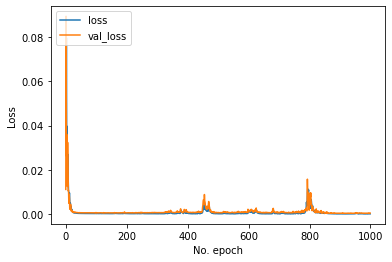

In [22]:
#Save model and plot loss

model.save('save_TopOpt_model_v7.h5')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

[[ 0.13474457 -1.92881274]
 [-0.45489681 -2.22183895]
 [-0.67784047 -2.22326446]
 [-0.86345905 -2.18074775]]
(1, 4, 2) (1, 147, 2)


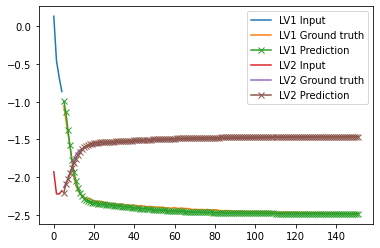

(10, 147, 2)
(1, 147, 2)


In [19]:
#Predicting with model -------------------------------------

#Compare predictions with ground truth
sample_no = 1

n_steps_ = int((seq_length-pred) )
x2 = x_test[sample_no,:,:] 
print (x2)
x2 = tf.expand_dims(x2, 0)  
prediction = model.predict (x2)
print (x2.shape, prediction.shape)

plt.plot (np.linspace (0, seq_length-pred,num= seq_length-pred ), x2[0,:,0], '-')    
plt.plot (np.linspace (seq_length-pred+1,seq_length,num=  pred ), y_test[1,:,0])
plt.plot (np.linspace (seq_length-pred+1,seq_length,num=  pred ),  prediction[0,:,0], 'x-')
plt.plot (np.linspace (0, seq_length-pred,num= seq_length-pred ), x2[0,:,1], '-')    
plt.plot (np.linspace (seq_length-pred+1,seq_length,num=  pred ), y_test[1,:,1])
plt.plot (np.linspace (seq_length-pred+1,seq_length,num=  pred ),  prediction[0,:,1], 'x-')

plt.legend(['LV1 Input', 'LV1 Ground truth', 'LV1 Prediction','LV2 Input', 'LV2 Ground truth', 'LV2 Prediction'])
plt.show()

print (y_test.shape)
print (prediction.shape)

np.savetxt("F3_y_test.csv", y_test[1,:,:], delimiter=" ")
np.savetxt("F3_prediction.csv", prediction[0,:,:], delimiter=" ")